In [1]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_crime_data
from datetime import datetime
import prepare
import seaborn as sns
from wrangle import *
from explore import *

In [2]:
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
df = get_crime_data(use_cache = False)

Acquiring data from api


In [4]:
df = wrangle_crime_data()

Using cached csv


In [5]:
df.crime_type.count()

349581

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436549
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        349581 non-null  object        
 1   family_violence   349581 non-null  object        
 2   occurrence_time   349581 non-null  datetime64[ns]
 3   occurrence_date   349581 non-null  datetime64[ns]
 4   report_time       349581 non-null  datetime64[ns]
 5   report_date       349581 non-null  datetime64[ns]
 6   location_type     349581 non-null  object        
 7   address           349581 non-null  object        
 8   zip_code          349581 non-null  float64       
 9   council_district  349581 non-null  float64       
 10  sector            349581 non-null  object        
 11  district          349581 non-null  object        
 12  latitude          349581 non-null  float64       
 13  longitude         349581 non-null  float64       
 14  

In [7]:
#Assign my .shp file to a variable named “asutin_map”
#austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [8]:
#austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [9]:
#austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})

In [10]:
#austin_map = austin_map.astype({"zip_code": float}, errors='raise') 

In [11]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
#new_df = austin_map.merge(df, on ='zip_code')

In [12]:
#new_df.to_csv('Geo_Crime_Reports.csv')

In [13]:
#new_df.info()

In [15]:
#new_df.head()

In [16]:
#Crime_type by zip_code
#fig, ax = plt.subplots(1, figsize=(8, 8))
#plt.xticks(rotation=90)
#new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
#bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
#bar_info._A = []
#cbar = fig.colorbar(bar_info)

# We predict that there is a relationship between higher seasonal levels of crime and clearance status.

In [17]:
train, validate, test = prepare.split_data(df)

In [18]:
train.shape

(195764, 17)

In [19]:
train2 = train.copy()

In [20]:
#df['occurrence_date']= pd.to_datetime(df['occurrence_date'])
train2 = train2.set_index('occurrence_date').sort_index()

In [21]:
#Split by month first
train2['month'] = train2.index.month_name()
train2['weekdays'] = train2.index.day_name()
train2['year'] = train2.index.year

In [22]:
#train2.groupby(train2.occurrence_date.dt.month).crime_type.count().idxmax()

In [23]:
y = train2.groupby(['weekdays','year'])['crime_type'].count()

In [24]:
y

weekdays   year
Friday     2018    7601
           2019    8069
           2020    7505
           2021    6667
Monday     2018    7226
           2019    7540
           2020    7099
           2021    6410
Saturday   2018    7441
           2019    7641
           2020    6955
           2021    6114
Sunday     2018    7074
           2019    7419
           2020    6817
           2021    6078
Thursday   2018    7116
           2019    7081
           2020    7144
           2021    6071
Tuesday    2018    6970
           2019    7295
           2020    7037
           2021    5901
Wednesday  2018    7039
           2019    7082
           2020    7336
           2021    6036
Name: crime_type, dtype: int64

In [25]:
y_max = train2.groupby(['weekdays','year'])['crime_type'].count().max()

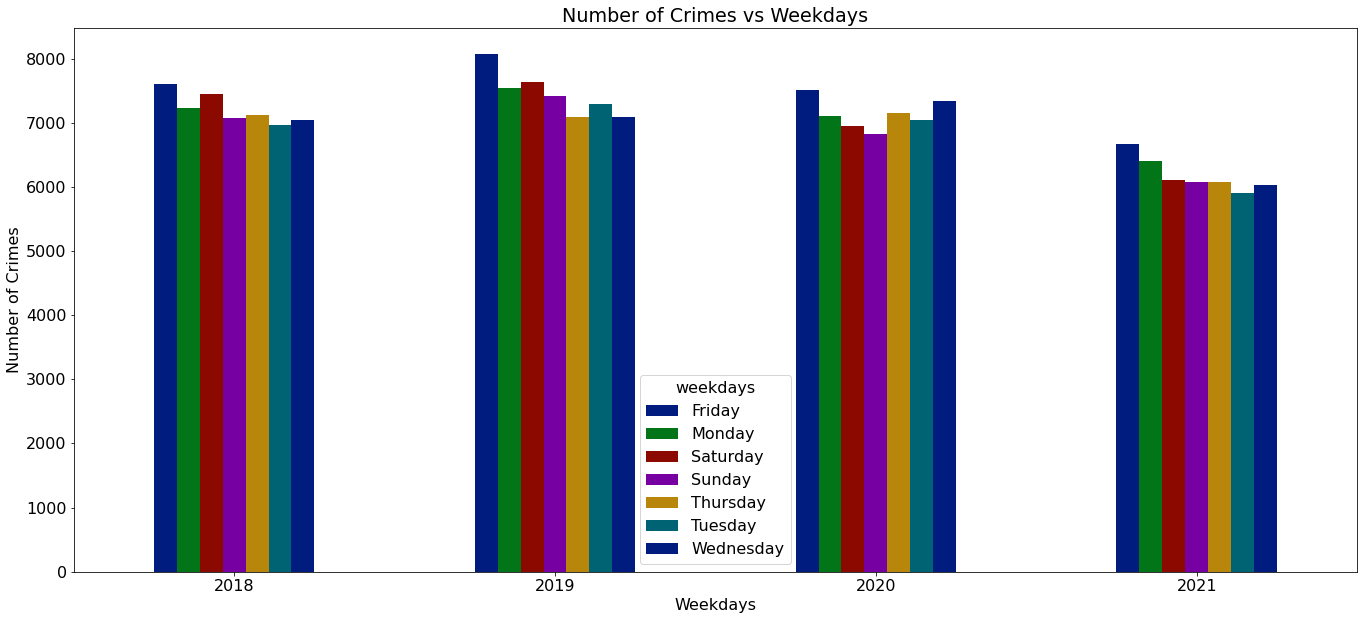

In [42]:
#Take a look at all the crime types
train2['weekdays'] = pd.Categorical(train2['weekdays'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#overall_mean = df.groupby('month').crime_type.value_counts()
#Assuming 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 =Saturday
y.unstack(0).plot.bar()
#sns.barplot(x=None, y = y, data = y, ci = None)
plt.title("Number of Crimes vs Weekdays")
plt.xlabel("Weekdays")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

In [27]:
friday_only = ['Friday']

In [28]:
subset_friday = train2.copy()

In [29]:
subset_friday = subset_friday[subset_friday.weekdays.isin(friday_only)]#With just friday only

In [30]:
subset_not_friday = train2.copy()

In [31]:
subset_not_friday = subset_not_friday[~subset_not_friday.weekdays.isin(friday_only)]#Without friday

### Stats Test

We'll be testing the following hypothesis:

$H_0$: There is no difference in crime levels between Fridays and other days of the week.
<br>
$H_a$: There is difference in crime levels between Fridays and other days of the week.

In [32]:
#Do 1 sample t-test compare friday vs the rest
#Need to subset the data just friday only and other exclude the friday and do 1 sample ttest
t_test_ind(subset_not_friday.cleared, subset_friday.cleared)

The t value between the two samples is 0.6367 and the P-Value is 0.5243498607925576.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


In [38]:
train2.head()

,crime_type,family_violence,occurrence_time,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,month,weekdays,year
occurrence_date,,,,,,,,,,,,,,,,,,,
2018-01-01,IDENTITY THEFT,N,2018-01-01 12:00:00,2018-05-09 12:04:00,2018-05-09,RESIDENCE / HOME,6002 PALM CIR,78741.0,3.0,HE,3,30.234826,-97.701869,cleared by exception,2018-05-09,True,January,Monday,2018
2018-01-01,HARASSMENT,Y,2018-01-01 19:14:00,2018-01-01 19:14:00,2018-01-01,RESIDENCE / HOME,1100 REINLI ST,78723.0,4.0,ID,5,30.317020,-97.703333,not cleared,2018-01-22,False,January,Monday,2018
2018-01-01,PUBLIC INTOXICATION,N,2018-01-01 16:01:00,2018-01-01 18:57:00,2018-01-01,PARKING /DROP LOT/ GARAGE,CAMERON RD / CORONA DR,78723.0,4.0,ID,5,30.313096,-97.704959,cleared by arrest,2018-01-01,True,January,Monday,2018
2018-01-01,ASSAULT W/INJURY-FAM/DATE VIOL,Y,2018-01-01 20:27:00,2018-01-01 21:19:00,2018-01-01,RESIDENCE / HOME,11316 JOLLYVILLE RD,78759.0,10.0,AD,7,30.411060,-97.748087,cleared by arrest,2018-01-01,True,January,Monday,2018
2018-01-01,THEFT,N,2018-01-01 19:25:00,2018-01-04 19:25:00,2018-01-04,OTHER / UNKNOWN,2205 DOVEHILL DR,78744.0,2.0,FR,5,30.192363,-97.756788,not cleared,2018-05-18,False,January,Monday,2018


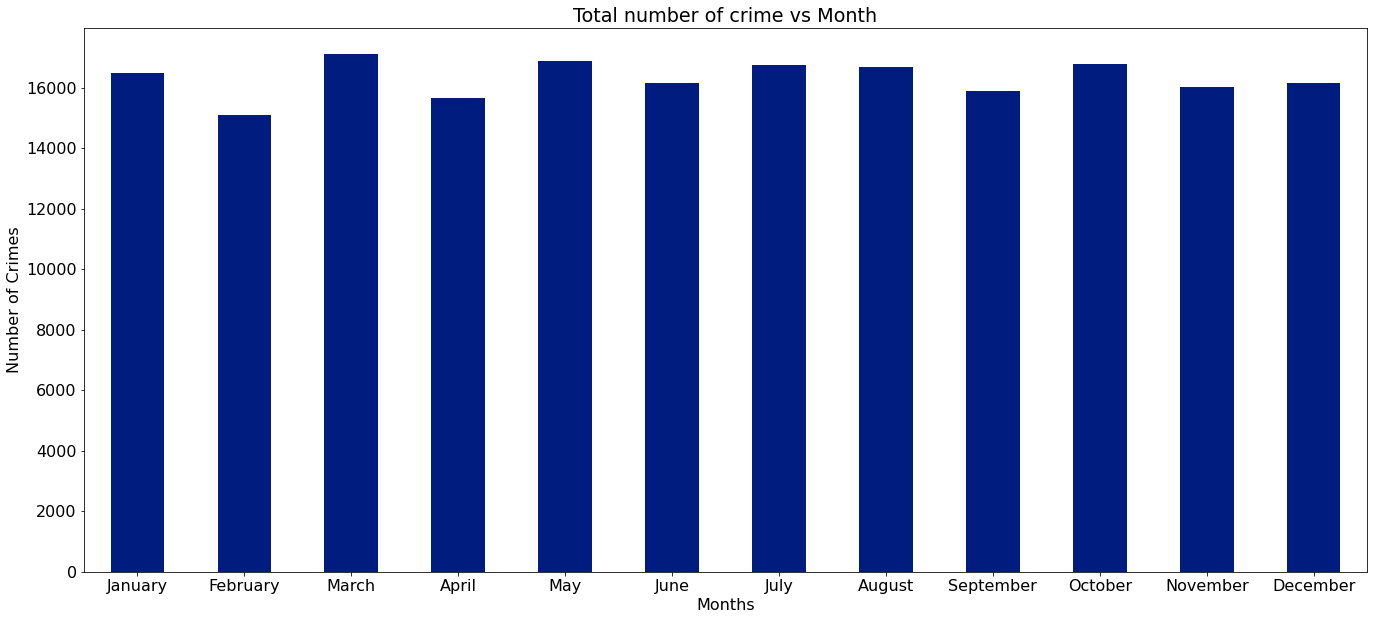

In [39]:
#Take a look at all the crime types
train2['month'] = pd.Categorical(train2['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
#overall_mean = df.groupby('month').crime_type.value_counts()
train2.groupby('month').crime_type.count().plot.bar()
plt.title("Total number of crime vs Month")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

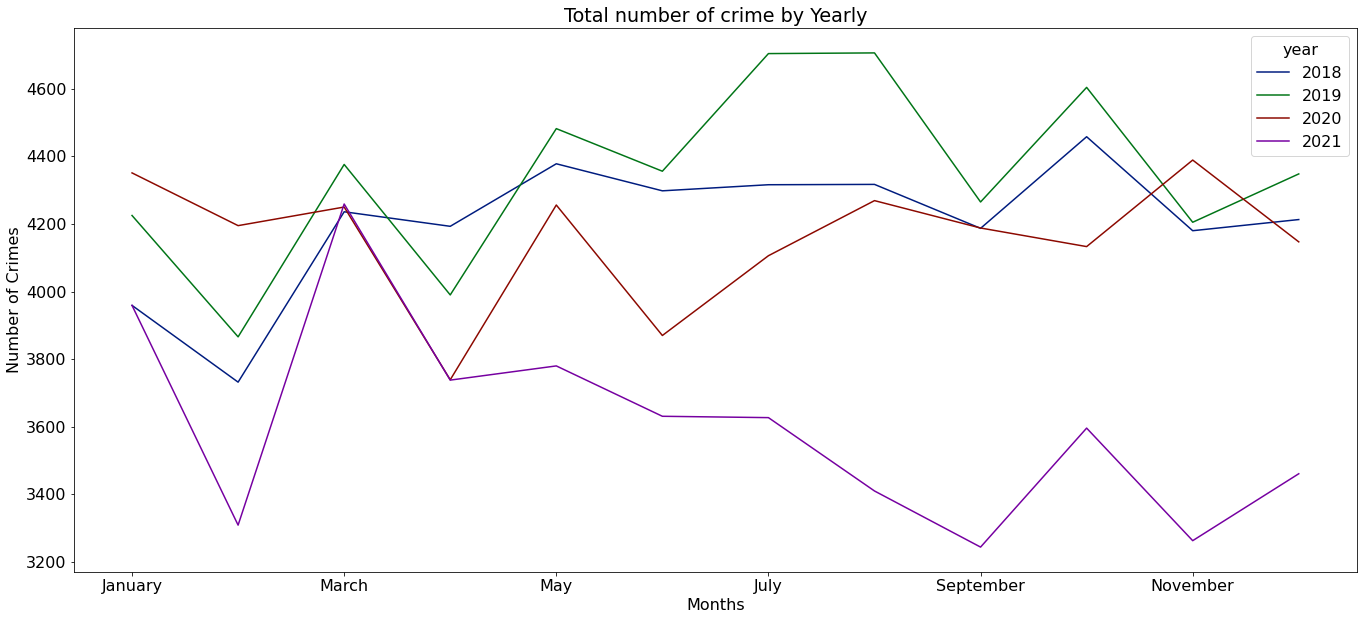

In [34]:
train2.groupby(['year', 'month']).crime_type.count().unstack(0).plot.line()
plt.title("Total number of crime by Yearly")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

In [37]:
train2.crime_type.count()

195764

In [35]:
train2.month.value_counts()

March        17121
May          16896
October      16791
July         16753
August       16702
January      16494
December     16169
June         16155
November     16037
September    15884
April        15660
February     15102
Name: month, dtype: int64

In [36]:
train2.groupby(['year', 'month']).crime_type.count()

year  month    
2018  January      3959
      February     3732
      March        4236
      April        4193
      May          4378
      June         4298
      July         4316
      August       4317
      September    4187
      October      4458
      November     4180
      December     4213
2019  January      4225
      February     3866
      March        4376
      April        3990
      May          4482
      June         4356
      July         4704
      August       4706
      September    4265
      October      4604
      November     4205
      December     4348
2020  January      4351
      February     4195
      March        4250
      April        3739
      May          4256
      June         3870
      July         4106
      August       4269
      September    4188
      October      4133
      November     4389
      December     4147
2021  January      3959
      February     3309
      March        4259
      April        3738
      May          3780


#### Take away 
- From the visuals, we can see that Friday (2019) has higest, all the months have almost the same number of crime and year of 2019. But still need to take a look deeper into which weekday of the year has the higest number.